## Import packages

In [1]:
# !pip install schema
# !pip install tensorflow
# !pip install keras
# !pip install pillow
# !pip install torch
# !pip install torchvision
# !pip install tensorflow
# !pip install torchinfo

In [2]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
import pytest
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import tensorflow

import os
import pickle
from schema import Schema, Or
from numpy import array

from __future__ import print_function, division
import os
import torch

from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image, ImageDraw
import ujson as json

## Load and Display Data

In [3]:
books = np.load("./npy/full-numpy_bitmap-book.npy")
books.reshape((np.shape(books)[0], 28, 28))
book0 = books[0].reshape(28,28)
# print(book0)

breads = np.load("./npy/full-numpy_bitmap-bread.npy")
breads.reshape((np.shape(breads)[0], 28, 28))
bread0 = breads[0].reshape(28,28)

airplanes = np.load("./npy/full_numpy_bitmap_airplane.npy")
airplanes.reshape((np.shape(airplanes)[0], 28, 28))
airplane0 = airplanes[0].reshape(28,28)

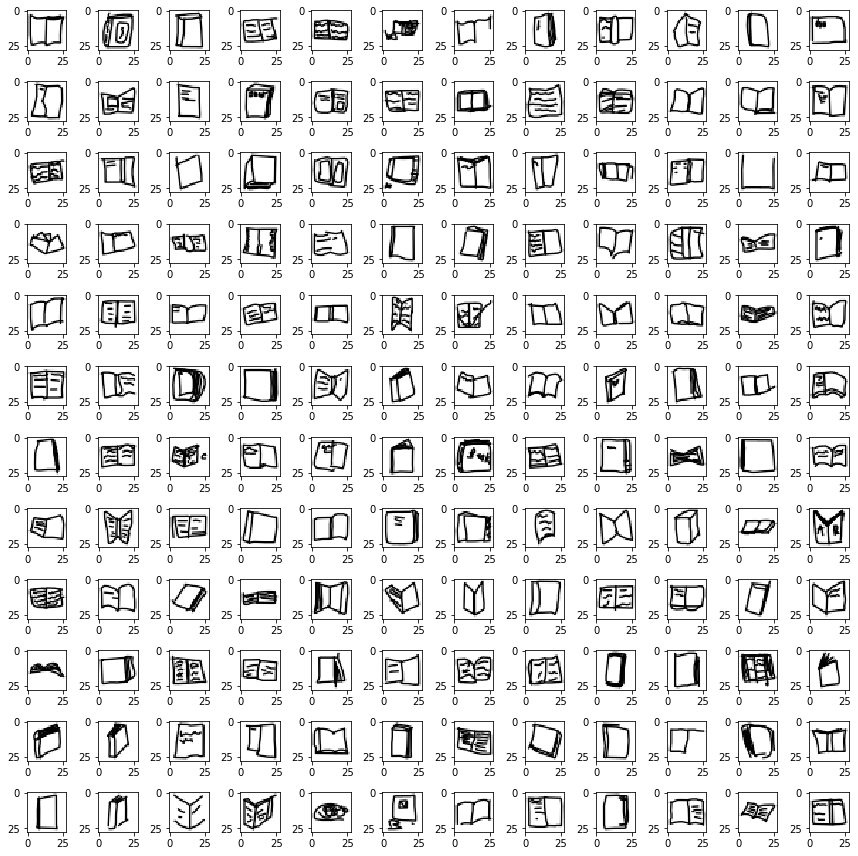

In [4]:
# Some example data to display
n = 12
fig, axs = plt.subplots(n, n, figsize=(n,n))
for i in range(n):
    for j in range(n):
        axs[i, j].imshow(books[i*n+j].reshape((28,28)), interpolation='nearest',cmap ="Greys")
fig.tight_layout()

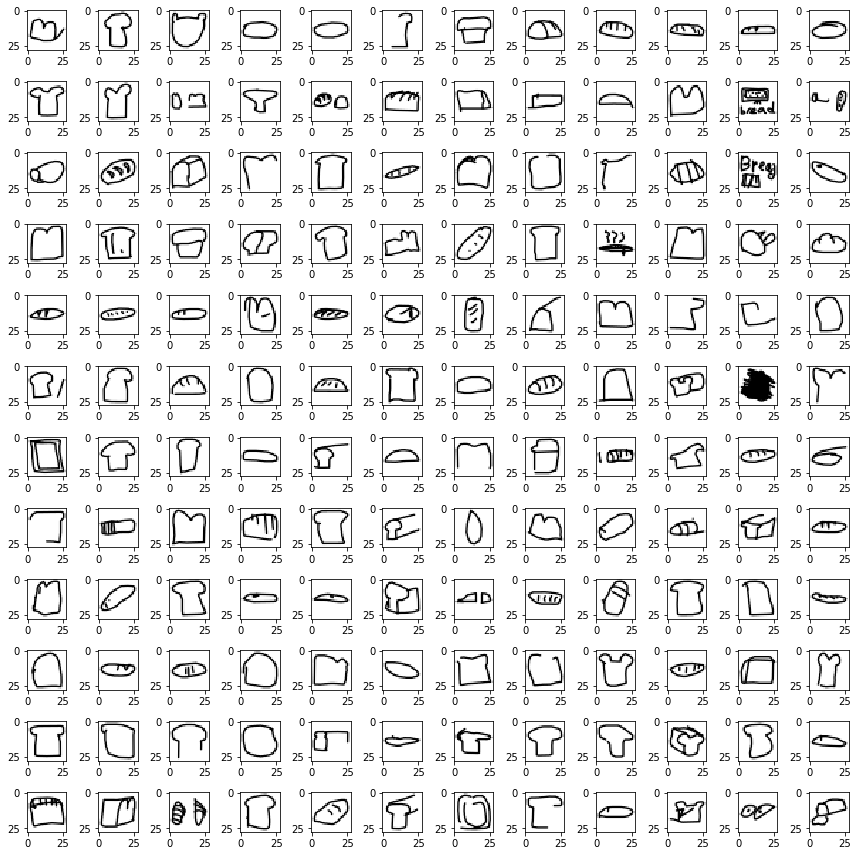

In [5]:
# Some example data to display
n = 12
fig, axs = plt.subplots(n, n, figsize=(n,n))
for i in range(n):
    for j in range(n):
        axs[i, j].imshow(breads[i*n+j].reshape((28,28)), interpolation='nearest',cmap ="Greys")
fig.tight_layout()

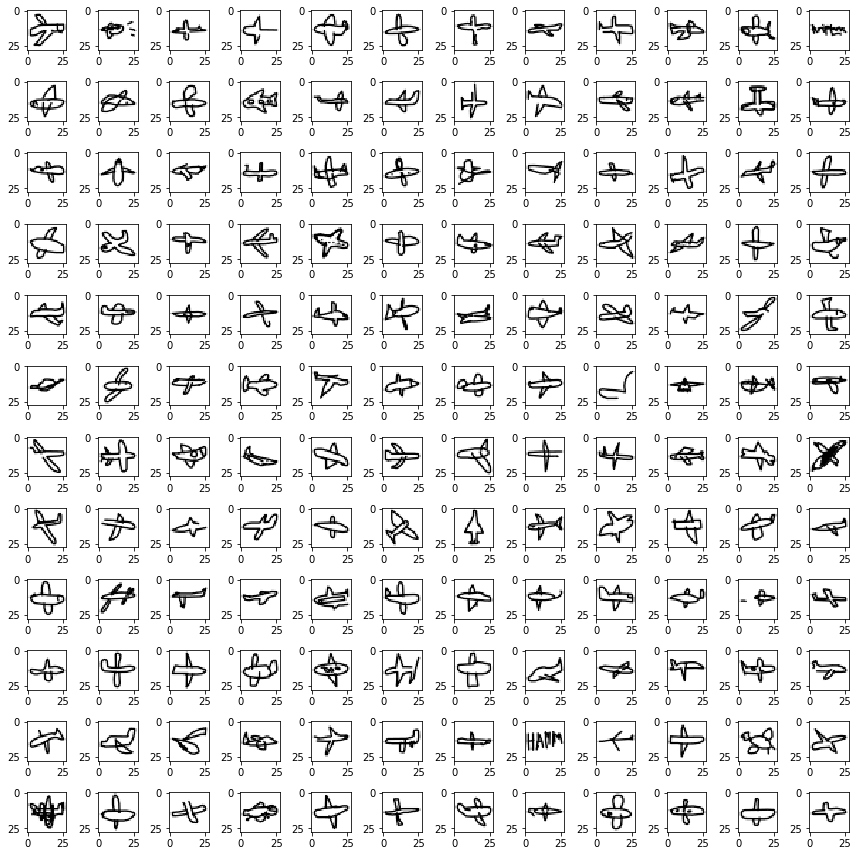

In [6]:
# Some example data to display
n = 12
fig, axs = plt.subplots(n, n, figsize=(n,n))
for i in range(n):
    for j in range(n):
        axs[i, j].imshow(airplanes[i*n+j].reshape((28,28)), interpolation='nearest',cmap ="Greys")
fig.tight_layout()

In [7]:
def open_ndjson(path: str) -> pd.DataFrame:
    return pd.DataFrame.from_records(map(json.loads, open(path, encoding="utf8")))

book_df = open_ndjson("./data/book.ndjson")
# print(book_df.head())
book_df_t = book_df[book_df['recognized'] == True]
# book_df_t['drawing'] = book_df_t['drawing'].apply(lambda x: np.array(x,dtype=object))

bread_df = open_ndjson("./data/bread.ndjson")
# print(bread_df.head())
bread_df_t = bread_df[bread_df['recognized'] == True]
# bread_df_t['drawing'] = bread_df_t['drawing'].apply(lambda x: np.array(x,dtype=object))


airplane_df = open_ndjson("./data/airplane.ndjson")
airplane_df_t = airplane_df[airplane_df['recognized'] == True]
# airplane_df_t['drawing'] = airplane_df_t['drawing'].apply(lambda x: np.array(x,dtype=object))
airplane_df_t.head()

,word,countrycode,timestamp,recognized,key_id,drawing
0,airplane,US,2017-03-08 21:12:07.26604 UTC,True,5152802093400064,"[[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, ..."
2,airplane,US,2017-03-23 02:08:35.22998 UTC,True,6577010312740864,"[[[90, 88, 95, 104, 112, 122], [65, 31, 12, 0,..."
3,airplane,US,2017-03-10 00:35:17.53197 UTC,True,5643224746033152,"[[[82, 49, 15, 4, 0, 5, 30, 85, 89, 93, 112, 1..."
4,airplane,IL,2017-01-23 18:11:11.65817 UTC,True,6670046841536512,"[[[64, 38, 23, 8, 0, 6, 26, 68], [74, 77, 84, ..."
5,airplane,US,2017-03-02 19:06:55.49465 UTC,True,5509429904539648,"[[[195, 164, 127, 40, 13, 0, 4, 28, 93, 172, 2..."


## CNN
reference: https://data-flair.training/blogs/python-deep-learning-project-handwritten-digit-recognition/
Create GUI to predict digits

https://www.tensorflow.org/tutorials/images/cnn
plot score

In [8]:
def reshape_3d(data):
    nx = np.shape(data)[0]
    ny = 28
    nz = 28
    data_3d = np.empty((nx,ny,nz))
    count = 0
    for k in range(nx):
        for j in range(ny):
            for i in range(nz):
                data_3d[k,j,i] = data[k,ny*j+i]
                count += 1
    return data_3d

In [9]:
airplanes_3d = reshape_3d(airplanes)
books_3d = reshape_3d(books)
breads_3d = reshape_3d(breads)
# airplanes.reshape(np.shape(airplanes)[0], 28, 28)
print(np.shape(airplanes))
print(np.shape(airplanes_3d))

(151623, 784)
(151623, 28, 28)


In [10]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import utils as np_utils

class_names = ['book', 'bread','airplane']
num_classes = len(class_names)
len_books, len_breads, len_airplanes = np.shape(books)[0], np.shape(breads)[0], np.shape(airplanes)[0]

images = np.concatenate((books_3d, breads_3d, airplanes_3d), axis=0)
labels = np.concatenate((['0']*len_books, ['1']*len_breads, ['2']*len_airplanes), axis=0)



indices = np.random.permutation(np.shape(labels)[0])
idx = int(np.shape(labels)[0]*8/10)
training_idx, test_idx = indices[:idx], indices[idx:]
x_train = images[training_idx,:,:]
x_test = images[test_idx,:,:]
y_train = labels[training_idx]
y_test = labels[test_idx]

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# convert class vectors to binary class matrices
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (313245, 28, 28, 1)
313245 train samples
78312 test samples


In [ ]:
batch_size = 128
num_classes = num_classes
epochs = 2
def createModel():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
    return model

In [ ]:
# model = createModel()
# hist = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test, y_test))
# print("The model has successfully trained")
# model.save('cnn:first try')
# print("Saving the model as cnn:first try")

In [ ]:
# plt.plot(hist.history['accuracy'], label='accuracy')
# plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
# # test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

# Define the CNN Model

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torchinfo import summary

In [17]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, features, labels, transform = None):
        'Initialization'
        self.features = features
        self.labels = labels
        self.transform = transform

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

  def __getitem__(self, index):
        'Generates one sample of data'
        x = self.features[index,:,:]
        y  = self.labels[index]

        return x, y

In [18]:
batch_size = 128

trainset = Dataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = Dataset(x_test, y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ['book', 'bread','airplane']

In [23]:
np.shape(trainset.labels)

(313245, 3)

In [24]:
#Define a Convolutional Neural Network    
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
    
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=32,kernel_size=3,padding=1,stride=1)
      self.conv2 = nn.Conv2d(32, 64,kernel_size=3,padding=1,stride=1)
      self.dropout1 = nn.Dropout2d(0.25)
      self.dropout2 = nn.Dropout2d(0.5)
      self.fc1 = nn.Linear(9216, 128)
      self.fc2 = nn.Linear(128, 3)

    # x represents our data
    def forward(self, x):
      # Pass data through conv1
      x = self.conv1(x)
      # Use the rectified-linear activation function over x
      x = F.relu(x)
        
      x = self.conv2(x)
      x = F.relu(x)

      # Run max pooling over x
      x = F.max_pool2d(x, 2)
      # Pass data through dropout1
      x = self.dropout1(x)
      # Flatten x with start_dim=1
      x = torch.flatten(x, 1)
      # Pass data through fc1
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout2(x)
      x = self.fc2(x)

      # Apply softmax to x
      output = F.log_softmax(x, dim=1)
      return output

cnn = Net()
print(cnn)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [26]:
cnn(x_train)

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [ ]:
enumerate(testloader, 0)

In [ ]:
for epoch in range(10): 
    running_loss = 0.0
    for i, data in enumerate(trainloader.dataset, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
#Test the network on the test data
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
#load back in our saved model
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [ ]:
#how the network performs on the whole dataset?
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

## Abtract Class
reference: https://github.com/schmidtbri/simple-ml-model-abc/blob/master/iris_predict.py

https://schmidtbri.github.io/ml-model-abc-improvements/iris_predict.html

https://schmidtbri.github.io/ml-model-abc-improvements/ml_model_abc.html#ml_model_abc.MLModel.description

https://github.com/schmidtbri/simple-ml-model-abc/blob/master/iris_predict.py

In [ ]:
#Quote: 
from abc import ABC, abstractmethod


class Model(ABC):
    @property
    @abstractmethod
    def input_schema(self):
        raise NotImplementedError()

    @property
    @abstractmethod
    def output_schema(self):
        raise NotImplementedError()

    @abstractmethod
    def __init__(self):
        raise NotImplementedError()

    @abstractmethod
    def predict(self, data):
        self.input_schema.validate(data)


class ModelException(Exception):
    """ Exception type used to raise exceptions within MLModel derived classes """
    def __init__(self,*args,**kwargs):
        Exception.__init__(self, *args, **kwargs)

In [ ]:
class CnnModel(Model):
    input_schema = Schema({'drawing': np.ndarray})

    # the output of the model will be one of three strings
    output_schema = Schema({'recognized': bool})

    def __init__(self):
        dir_path = os.path.dirname(os.path.realpath(__file__))
        file = open(os.path.join(dir_path, "model_files", "svc_model.pickle"), 'rb')
        self._svm_model = pickle.load(file)
        file.close()

    def predict(self, data):
        # calling the super method to validate against the input_schema
        super().predict(data=data)

        # converting the incoming dictionary into a numpy array that can be accepted by the scikit-learn model
        X = array([data["sepal_length"], data["sepal_width"], data["petal_length"], data["petal_width"]]).reshape(1, -1)

        # making the prediction and extracting the result from the array
        y_hat = int(self._svm_model.predict(X)[0])

        #converting the prediction into a string that will match the output schema of the model
        # this list will map the output of the scikit-learn model to the output string expected by the schema
        targets = ['setosa', 'versicolor', 'virginica']
        species = targets[y_hat]

        return {"species": species}